In [1]:
# maybe the best thing to do is to concat all the data
# that I want:
# league, match, player, hero, pick, ban, team, etc
# that way it should be easy to query for stats?

In [2]:
import pandas as pd
import json
import glob
import datetime
import numpy as np

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'font.size': 16})

In [4]:
def read_json_file(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [5]:
hero_map = pd.read_json("hero_map.json")
hero_map.set_index('idx', inplace=True)

In [6]:
hero_map

hero
idx             
114  Monkey King
129         Mars
63        Weaver
74       Invoker
29    Tidehunter
..           ...
22          Zeus
50        Dazzle
80    Lone Druid
37       Warlock
82         Meepo

[121 rows x 1 columns]

In [7]:
filenames = glob.glob("stratz_match_data_2021_2022_tour_1/*")

In [8]:
filenames

['stratz_match_data_2021_2022_tour_1/NA.json',
 'stratz_match_data_2021_2022_tour_1/SEA.json',
 'stratz_match_data_2021_2022_tour_1/EEU.json',
 'stratz_match_data_2021_2022_tour_1/SA.json',
 'stratz_match_data_2021_2022_tour_1/WEU.json',
 'stratz_match_data_2021_2022_tour_1/CN.json']

In [9]:
data = {}
for filename in filenames:
    key = filename.split("/")[-1].split(".")[0]
    data[key] = read_json_file(filename)

# first get list of all matches, datetime, team1, team2 

In [10]:
data["NA"]["data"]["league"]['matches'][0].keys()

dict_keys(['id', 'didRadiantWin', 'startDateTime', 'endDateTime', 'durationSeconds', 'firstBloodTime', 'clusterId', 'replaySalt', 'direTeamId', 'radiantTeamId', 'direTeam', 'radiantTeam', 'series', 'stats', 'players'])

In [12]:
data["NA"]["data"]["league"]['matches'][0]['didRadiantWin']

True

In [13]:
data["NA"]["data"]["league"]['matches'][0]['direTeam']['id']

8376426

In [14]:
data["NA"]["data"]["league"]['matches'][0]['direTeam']['name']

'Wildcard Gaming'

In [15]:
ks = ['id', 'radiantTeamId', 'direTeamId', 'startDateTime', 'firstBloodTime']

In [16]:
[data["NA"]["data"]["league"]['matches'][0][k] for k in ks]

[6388378756, 7819028, 8376426, 1642723201, -14]

In [17]:
data["NA"]["data"]["league"]['matches'][0]['direTeamId']

8376426

In [18]:
data["NA"]["data"]["league"]['matches'][0]['direTeamId']

8376426

In [11]:
data["NA"]["data"]["league"]['matches'][0]['series']

{'id': 634542,
 'type': 'BEST_OF_THREE',
 'teamOneWinCount': 0,
 'teamTwoWinCount': 2,
 'teamOne': {'id': 8376426, 'name': 'Wildcard Gaming'},
 'teamTwo': {'id': 7819028, 'name': '4 Zoomers'},
 'winningTeamId': 7819028,
 'matches': [{'id': 6388378756}, {'id': 6388326281}]}

In [56]:
data["NA"]["data"]["league"]['matches'][0]['id']

6388378756

In [61]:
[ms['id'] for ms in data["NA"]["data"]["league"]['matches'][0]['series']['matches']]

[6388378756, 6388326281]

In [19]:
def convert_time(s):
    return datetime.datetime.fromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S.%f')

In [20]:
cols = ks
cols += ['direTeam', 'radiantTeam']

In [21]:
len(cols)

7

In [62]:
def get_rows_df(data_matches, region):
    ks = ['id', 'radiantTeamId', 'direTeamId', 'startDateTime', 'firstBloodTime', 'didRadiantWin']
    rows = []
    for i, m in enumerate(data_matches):
        row = {k:data_matches[i][k] for k in ks}

        row['radiantTeam'] = data_matches[i]['radiantTeam']['name']
        row['direTeam'] = data_matches[i]['direTeam']['name']
        row['startDateTime'] = convert_time(row['startDateTime'])
        
        
        row['series_type'] = data_matches[i]['series']['type']
        
        row['series_match_ids'] = [match_ids['id'] for match_ids in data_matches[i]['series']['matches']]
        
        
        row['region'] = region

        rows.append(list(row.values()))
        
    cols = list(row.keys())
    df = pd.DataFrame(rows, columns=cols)
    return df

In [63]:
data.keys()

dict_keys(['NA', 'SEA', 'EEU', 'SA', 'WEU', 'CN'])

In [64]:
dfs = []
for k in data.keys():
    dfs.append(get_rows_df(data_matches=data[k]["data"]["league"]['matches'], region=k))

In [65]:
df = pd.concat(dfs)
df['startDateTime'] = pd.to_datetime(df['startDateTime'])
df = df.reset_index(drop=True)

In [66]:
df

id  radiantTeamId  direTeamId       startDateTime  \
0    6388378756        7819028     8376426 2022-01-21 00:00:01   
1    6388326281        8376426     7819028 2022-01-20 22:55:08   
2    6388242658        8260983          39 2022-01-20 21:26:05   
3    6388176598             39     8260983 2022-01-20 20:23:58   
4    6386614289             39     7390454 2022-01-20 00:06:45   
..          ...            ...         ...                 ...   
414  6356868459             15     6209166 2022-01-03 10:21:46   
415  6356788698        6209166          15 2022-01-03 09:19:57   
416  6356694527             15     6209166 2022-01-03 08:04:22   
417  6356555723              4     8118983 2022-01-03 05:58:32   
418  6356495774              4     8118983 2022-01-03 04:55:29   

     firstBloodTime  didRadiantWin      radiantTeam         direTeam  \
0               -14           True        4 Zoomers  Wildcard Gaming   
1               -23          False  Wildcard Gaming        4 Zoomers   
2               -44           True          Undying    Evil Geniuses   
3               138          False    Evil Geniuses          Undying   
4               242           True    Evil Geniuses      Quincy Crew   
..              ...            ...              ...              ...   
414             142           True          PSG.LGD       Team Aster   
415             -19          False       Team Aster          PSG.LGD   
416             110          False          PSG.LGD       Team Aster   
417             183           True            EHOME   phoenix gaming   
418             134           True            EHOME   phoenix gaming   

       series_type                      series_match_ids region  
0    BEST_OF_THREE              [6388378756, 6388326281]     NA  
1    BEST_OF_THREE              [6388378756, 6388326281]     NA  
2    BEST_OF_THREE              [6388242658, 6388176598]     NA  
3    BEST_OF_THREE              [6388242658, 6388176598]     NA  
4    BEST_OF_THREE              [6386614289, 6386555719]     NA  
..             ...                                   ...    ...  
414  BEST_OF_THREE  [6356868459, 6356788698, 6356694527]     CN  
415  BEST_OF_THREE  [6356868459, 6356788698, 6356694527]     CN  
416  BEST_OF_THREE  [6356868459, 6356788698, 6356694527]     CN  
417  BEST_OF_THREE              [6356555723, 6356495774]     CN  
418  BEST_OF_THREE              [6356555723, 6356495774]     CN  

[419 rows x 11 columns]

In [68]:
df['series_type'].unique()

array(['BEST_OF_THREE', 'BEST_OF_ONE'], dtype=object)

In [69]:
# tiebreaker games are not nesseccarily Bo1
df[df['series_type']=='BEST_OF_ONE']

id  radiantTeamId  direTeamId       startDateTime  \
277  6389790676        1838315     2586976 2022-01-21 18:33:09   
278  6389696277        8291895     7554697 2022-01-21 17:37:37   

     firstBloodTime  didRadiantWin      radiantTeam      direTeam  \
277             147          False      Team Secret            OG   
278             224           True  Tundra Esports   Nigma Galaxy   

     series_type series_match_ids region  
277  BEST_OF_ONE     [6389790676]    WEU  
278  BEST_OF_ONE     [6389696277]    WEU

In [27]:
all_teams = pd.concat([df['direTeam'], df['radiantTeam']]).unique()

In [28]:
all_teams

array(['Wildcard Gaming', '4 Zoomers', 'Evil Geniuses', 'Undying',
       'Quincy Crew', 'Arkosh Gaming', 'Black N Yellow',
       'Simply TOOBASED', 'T1', 'Fnatic', 'Team SMG',
       'Motivate.Trust Gaming', 'OB.Neon', 'Execration', 'BOOM Esports',
       'TNC Predator', 'Virtus.pro', 'HellRaisers', 'Mind Games',
       'AS Monaco Gambit', 'Team Empire', 'Natus Vincere', 'PuckChamp',
       'Team Spirit', 'beastcoast', 'Noping VPN', 'Hokori',
       'Thunder Predator', 'Infamous U.esports.', 'Lava BestPc',
       'APU King of Kings', 'SG esports', 'OG', 'Nigma Galaxy',
       'Team Secret', 'Team Tickles', 'Team Liquid', 'Coolguys',
       'Tundra Esports ', 'Alliance', 'Team Aster', 'PSG.LGD',
       'Vici Gaming', 'phoenix gaming', 'INVICTUS GAMING', 'EHOME',
       'LBZS', 'Royal Never Give Up'], dtype=object)

In [29]:
df1 = df[(df['direTeam']=='Wildcard Gaming') | (df['radiantTeam']=='Wildcard Gaming')]

In [30]:
df1

id  radiantTeamId  direTeamId       startDateTime  firstBloodTime  \
0   6388378756        7819028     8376426 2022-01-21 00:00:01             -14   
1   6388326281        8376426     7819028 2022-01-20 22:55:08             -23   
8   6384734705        7819028     8376426 2022-01-18 21:16:02             308   
9   6384641962        8376426     7819028 2022-01-18 19:58:17             363   
14  6374084318        8376426     8272699 2022-01-12 23:52:08             172   
15  6374036150        8272699     8376426 2022-01-12 22:55:10             337   
28  6361580107        8376426     8260932 2022-01-05 22:52:11             465   
29  6361508418        8376426     8260932 2022-01-05 21:47:55             229   
30  6361389582        8376426     8260932 2022-01-05 20:27:36             100   
35  6328538441        8376426     7390454 2021-12-18 21:57:09               6   
36  6328469168        8376426     7390454 2021-12-18 21:02:14             254   
37  6328352667        8376426     7390454 2021-12-18 19:55:16             314   
43  6320553119        8376426          39 2021-12-14 21:01:11              70   
44  6320448603        8376426          39 2021-12-14 19:58:07             269   
49  6311715872        8376426     8180753 2021-12-09 00:10:05             -38   
50  6311695839        8376426     8180753 2021-12-08 23:33:55             305   
64  6301207777        8260983     8376426 2021-12-01 20:51:31              58   
65  6301146538        8376426     8260983 2021-12-01 19:57:40             263   

    didRadiantWin      radiantTeam         direTeam region  
0            True        4 Zoomers  Wildcard Gaming     NA  
1           False  Wildcard Gaming        4 Zoomers     NA  
8            True        4 Zoomers  Wildcard Gaming     NA  
9           False  Wildcard Gaming        4 Zoomers     NA  
14           True  Wildcard Gaming  Simply TOOBASED     NA  
15          False  Simply TOOBASED  Wildcard Gaming     NA  
28           True  Wildcard Gaming   Black N Yellow     NA  
29           True  Wildcard Gaming   Black N Yellow     NA  
30          False  Wildcard Gaming   Black N Yellow     NA  
35          False  Wildcard Gaming      Quincy Crew     NA  
36           True  Wildcard Gaming      Quincy Crew     NA  
37          False  Wildcard Gaming      Quincy Crew     NA  
43           True  Wildcard Gaming    Evil Geniuses     NA  
44           True  Wildcard Gaming    Evil Geniuses     NA  
49           True  Wildcard Gaming    Arkosh Gaming     NA  
50           True  Wildcard Gaming    Arkosh Gaming     NA  
64           True          Undying  Wildcard Gaming     NA  
65          False  Wildcard Gaming          Undying     NA

Text(0.5, 0, 'date')

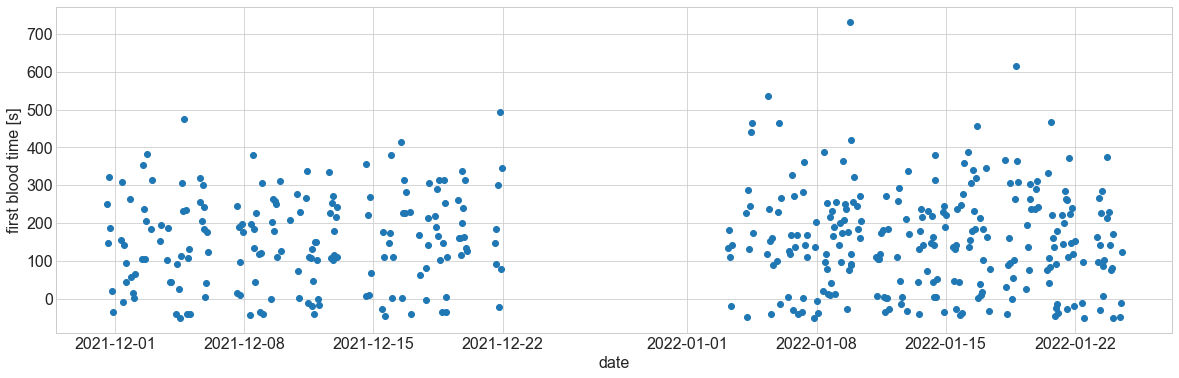

In [31]:
plt.figure(figsize=(20,6))
# plt.plot_date(df1['startDateTime'], df1['firstBloodTime'])
plt.plot_date(df['startDateTime'], df['firstBloodTime'])
plt.ylabel("first blood time [s]")
plt.xlabel("date")

# questions

What is the Quincy Crew win percentage?

In [32]:
team = "Quincy Crew"
df_qc = df[(df['direTeam']==team) | (df['radiantTeam']==team)]

In [33]:
df_qc

id  radiantTeamId  direTeamId       startDateTime  firstBloodTime  \
4   6386614289             39     7390454 2022-01-20 00:06:45             242   
5   6386555719        7390454          39 2022-01-19 22:55:11             312   
18  6372355177        7390454     8260932 2022-01-11 22:13:11             -25   
19  6372302305        8260932     7390454 2022-01-11 21:19:17             186   
20  6372216996        7390454     8260932 2022-01-11 20:11:41               4   
21  6367270891        8260983     7390454 2022-01-09 00:46:25             256   
22  6367227139        8260983     7390454 2022-01-08 23:48:21              13   
23  6367165592        8260983     7390454 2022-01-08 22:55:07             189   
35  6328538441        8376426     7390454 2021-12-18 21:57:09               6   
36  6328469168        8376426     7390454 2021-12-18 21:02:14             254   
37  6328352667        8376426     7390454 2021-12-18 19:55:16             314   
45  6316268602        8180753     7390454 2021-12-12 00:53:13             -15   
46  6316231679        8180753     7390454 2021-12-11 23:59:21               0   
56  6305915325        7819028     7390454 2021-12-05 01:12:24             -38   
57  6305881086        7390454     7819028 2021-12-05 00:12:13             133   
58  6305818918        7819028     7390454 2021-12-04 22:55:07             109   
66  6299811091        8272699     7390454 2021-11-30 21:09:00             -34   
67  6299750006        8272699     7390454 2021-11-30 20:06:52              22   

    didRadiantWin      radiantTeam        direTeam region  
4            True    Evil Geniuses     Quincy Crew     NA  
5           False      Quincy Crew   Evil Geniuses     NA  
18           True      Quincy Crew  Black N Yellow     NA  
19          False   Black N Yellow     Quincy Crew     NA  
20          False      Quincy Crew  Black N Yellow     NA  
21          False          Undying     Quincy Crew     NA  
22           True          Undying     Quincy Crew     NA  
23          False          Undying     Quincy Crew     NA  
35          False  Wildcard Gaming     Quincy Crew     NA  
36           True  Wildcard Gaming     Quincy Crew     NA  
37          False  Wildcard Gaming     Quincy Crew     NA  
45          False    Arkosh Gaming     Quincy Crew     NA  
46          False    Arkosh Gaming     Quincy Crew     NA  
56          False        4 Zoomers     Quincy Crew     NA  
57          False      Quincy Crew       4 Zoomers     NA  
58          False        4 Zoomers     Quincy Crew     NA  
66          False  Simply TOOBASED     Quincy Crew     NA  
67          False  Simply TOOBASED     Quincy Crew     NA

In [34]:
# logic
# if radiantWin==True and radiantTeam == Quincy Crew then Quincy Crew won
# if radiantWin==True and radiantTeam != Quincy Crew then Quincy Crew lost

In [35]:
mask_1 = ((df_qc['didRadiantWin']==True) & (df_qc['radiantTeam']==team))
mask_2 = ((df_qc['didRadiantWin']==False) & (df_qc['direTeam']==team))

In [36]:
df_qc.shape

(18, 9)

In [37]:
# games that Qunicy Crew won
df_qc[np.logical_or(mask_1, mask_2)].shape

(12, 9)

In [38]:
# games that Qunicy Crew won
df_qc[np.logical_or(mask_1, mask_2)]

id  radiantTeamId  direTeamId       startDateTime  firstBloodTime  \
18  6372355177        7390454     8260932 2022-01-11 22:13:11             -25   
19  6372302305        8260932     7390454 2022-01-11 21:19:17             186   
21  6367270891        8260983     7390454 2022-01-09 00:46:25             256   
23  6367165592        8260983     7390454 2022-01-08 22:55:07             189   
35  6328538441        8376426     7390454 2021-12-18 21:57:09               6   
37  6328352667        8376426     7390454 2021-12-18 19:55:16             314   
45  6316268602        8180753     7390454 2021-12-12 00:53:13             -15   
46  6316231679        8180753     7390454 2021-12-11 23:59:21               0   
56  6305915325        7819028     7390454 2021-12-05 01:12:24             -38   
58  6305818918        7819028     7390454 2021-12-04 22:55:07             109   
66  6299811091        8272699     7390454 2021-11-30 21:09:00             -34   
67  6299750006        8272699     7390454 2021-11-30 20:06:52              22   

    didRadiantWin      radiantTeam        direTeam region  
18           True      Quincy Crew  Black N Yellow     NA  
19          False   Black N Yellow     Quincy Crew     NA  
21          False          Undying     Quincy Crew     NA  
23          False          Undying     Quincy Crew     NA  
35          False  Wildcard Gaming     Quincy Crew     NA  
37          False  Wildcard Gaming     Quincy Crew     NA  
45          False    Arkosh Gaming     Quincy Crew     NA  
46          False    Arkosh Gaming     Quincy Crew     NA  
56          False        4 Zoomers     Quincy Crew     NA  
58          False        4 Zoomers     Quincy Crew     NA  
66          False  Simply TOOBASED     Quincy Crew     NA  
67          False  Simply TOOBASED     Quincy Crew     NA

In [39]:
# games that Qunicy Crew lost
df_qc[np.logical_not(np.logical_or(mask_1, mask_2))]

id  radiantTeamId  direTeamId       startDateTime  firstBloodTime  \
4   6386614289             39     7390454 2022-01-20 00:06:45             242   
5   6386555719        7390454          39 2022-01-19 22:55:11             312   
20  6372216996        7390454     8260932 2022-01-11 20:11:41               4   
22  6367227139        8260983     7390454 2022-01-08 23:48:21              13   
36  6328469168        8376426     7390454 2021-12-18 21:02:14             254   
57  6305881086        7390454     7819028 2021-12-05 00:12:13             133   

    didRadiantWin      radiantTeam        direTeam region  
4            True    Evil Geniuses     Quincy Crew     NA  
5           False      Quincy Crew   Evil Geniuses     NA  
20          False      Quincy Crew  Black N Yellow     NA  
22           True          Undying     Quincy Crew     NA  
36           True  Wildcard Gaming     Quincy Crew     NA  
57          False      Quincy Crew       4 Zoomers     NA

In [40]:
# win percentage
12/18 * 100

66.66666666666666

In [98]:
def get_win_percentage(df, team):
    df = df.copy()
    df = df[(df['direTeam']==team) | (df['radiantTeam']==team)]
    mask_1 = ((df['didRadiantWin']==True) & (df['radiantTeam']==team))
    mask_2 = ((df['didRadiantWin']==False) & (df['direTeam']==team))
    
    total_games = len(df)
    won_games = len(df[np.logical_or(mask_1, mask_2)])
    lost_games = len(df[np.logical_not(np.logical_or(mask_1, mask_2))])
    
    win_percentage = won_games / total_games * 100
    
    return win_percentage, total_games, won_games, lost_games

In [99]:
get_win_percentage(df, 'Undying')

(76.47058823529412, 17, 13, 4)

In [100]:
get_win_percentage(df, 'Evil Geniuses')

(64.70588235294117, 17, 11, 6)

In [101]:
get_win_percentage(df, 'Arkosh Gaming')

(13.333333333333334, 15, 2, 13)

In [102]:
get_win_percentage(df, 'OG')

(60.0, 20, 12, 8)

In [103]:
get_win_percentage(df, 'Team Liquid')

(68.42105263157895, 19, 13, 6)

In [104]:
get_win_percentage(df, 'PSG.LGD')

(82.35294117647058, 17, 14, 3)

In [105]:
get_win_percentage(df, 'Team Spirit')

(93.33333333333333, 15, 14, 1)

In [106]:
df['radiantTeam'].unique()

array(['4 Zoomers', 'Wildcard Gaming', 'Undying', 'Evil Geniuses',
       'Quincy Crew', 'Arkosh Gaming', 'Simply TOOBASED',
       'Black N Yellow', 'Team SMG', 'T1', 'Fnatic', 'Execration',
       'OB.Neon', 'BOOM Esports', 'TNC Predator', 'Motivate.Trust Gaming',
       'HellRaisers', 'Virtus.pro', 'AS Monaco Gambit', 'Mind Games',
       'Team Spirit', 'Team Empire', 'Natus Vincere', 'PuckChamp',
       'APU King of Kings', 'Hokori', 'Noping VPN', 'beastcoast',
       'Thunder Predator', 'Lava BestPc', 'SG esports',
       'Infamous U.esports.', 'Team Secret', 'Tundra Esports ', 'OG',
       'Team Tickles', 'Alliance', 'Coolguys', 'Nigma Galaxy',
       'Team Liquid', 'Royal Never Give Up', 'INVICTUS GAMING',
       'phoenix gaming', 'Vici Gaming', 'Team Aster', 'PSG.LGD', 'EHOME',
       'LBZS'], dtype=object)

In [107]:
get_win_percentage(df, 'PuckChamp')

(70.58823529411765, 17, 12, 5)

In [119]:
wp = []
for team in all_teams:
    wp.append([team] + list(get_win_percentage(df, team)))
wp = pd.DataFrame(wp, columns=['team', 'win_percentage', 'total_games', 'won_games', 'lost_games']).round(2)

In [122]:
wp.sort_values(by='win_percentage', ascending=False)

team  win_percentage  total_games  won_games  lost_games
27       Thunder Predator           93.75           16         15           1
23            Team Spirit           93.33           15         14           1
14           BOOM Esports           85.71           14         12           2
41                PSG.LGD           82.35           17         14           3
3                 Undying           76.47           17         13           4
22              PuckChamp           70.59           17         12           5
40             Team Aster           70.00           20         14           6
35           Team Tickles           68.75           16         11           5
36            Team Liquid           68.42           19         13           6
8                      T1           68.42           19         13           6
9                  Fnatic           66.67           18         12           6
38        Tundra Esports            66.67           18         12           6
4             Quincy Crew           66.67           18         12           6
2           Evil Geniuses           64.71           17         11           6
16             Virtus.pro           63.16           19         12           7
24             beastcoast           63.16           19         12           7
1               4 Zoomers           61.11           18         11           7
32                     OG           60.00           20         12           8
47    Royal Never Give Up           59.09           22         13           9
28    Infamous U.esports.           55.56           18         10           8
45                  EHOME           55.56           18         10           8
10               Team SMG           55.56           18         10           8
34            Team Secret           52.63           19         10           9
0         Wildcard Gaming           50.00           18          9           9
30      APU King of Kings           50.00           20         10          10
29            Lava BestPc           50.00           18          9           9
33           Nigma Galaxy           44.44           18          8          10
21          Natus Vincere           44.44           18          8          10
17            HellRaisers           44.44           18          8          10
42            Vici Gaming           41.18           17          7          10
46                   LBZS           41.18           17          7          10
12                OB.Neon           40.00           20          8          12
18             Mind Games           40.00           15          6           9
11  Motivate.Trust Gaming           36.84           19          7          12
26                 Hokori           35.29           17          6          11
25             Noping VPN           35.00           20          7          13
6          Black N Yellow           31.58           19          6          13
13             Execration           29.41           17          5          12
44        INVICTUS GAMING           29.41           17          5          12
7         Simply TOOBASED           28.57           14          4          10
20            Team Empire           23.53           17          4          13
19       AS Monaco Gambit           20.00           15          3          12
39               Alliance           20.00           15          3          12
15           TNC Predator           20.00           15          3          12
31             SG esports           18.75           16          3          13
5           Arkosh Gaming           13.33           15          2          13
43         phoenix gaming           12.50           16          2          14
37               Coolguys            6.67           15          1          14

## out of all the games across the dpc how many games when to three games

In [146]:
def bo3_stats(df):
    df = df.copy()
    df = df[df['series_type']=='BEST_OF_THREE']
    # only select the ones with more than one in the 'series_match_ids'
    # this gets rid of some Bo1 tiebreakers that are listed as Bo3.
    df = df[df['series_match_ids'].map(len) > 1]
    
    # matches that went to two games
    df_2 = df[df['series_match_ids'].map(len) == 2]
    
    # matches that went to three games
    df_3 = df[df['series_match_ids'].map(len) == 3]
    
    total_number_of_bo3_games = len(df)
    
    number_of_two_game_series = len(df_2)
    
    number_of_three_game_series = len(df_3)
    
    df_out = pd.DataFrame({
        'total_number_of_bo3_games': [total_number_of_bo3_games],
        'number_of_two_game_series': [number_of_two_game_series],
        'number_of_three_game_series': [number_of_three_game_series],
        'two_game_series_percentage':[number_of_two_game_series/total_number_of_bo3_games * 100],
        'thress_game_series_percentage':[number_of_three_game_series/total_number_of_bo3_games * 100],
    })
    
    return df_out.round(2)

In [147]:
bo3_stats(df)

total_number_of_bo3_games  number_of_two_game_series  \
0                        401                        230   

   number_of_three_game_series  two_game_series_percentage  \
0                          171                       57.36   

   thress_game_series_percentage  
0                          42.64

In [ ]:
# most games were won in the first two games i.e. were 2-0 's